In [ ]:
%load_ext autoreload
%autoreload 2

import os
os.environ["GX_ANALYTICS_ENABLED"] = "False"
import sys
import time
import yaml
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import glob
from dotenv import load_dotenv
import importlib

print("Starting configuration...")
start_time = time.time()

# 1. Detect Environment (avoid slow/hanging imports locally)
print("Detecting environment...")
IS_FABRIC = Path("/lakehouse/default/Files").exists()
if IS_FABRIC:
    try:
        from notebookutils import mssparkutils  # noqa: F401
    except Exception:
        mssparkutils = None
    print("Running in Microsoft Fabric")
else:
    print("Running Locally (Fabric path not found)")

print(f"Environment detection took {time.time() - start_time:.2f}s")

# 2. Define Paths based on Environment
if IS_FABRIC:
    BASE_DIR = Path("/lakehouse/default/Files")

    # Try to load .env from the Lakehouse Files root if it exists
    env_path = BASE_DIR / ".env"
    if env_path.exists():
        load_dotenv(dotenv_path=env_path)
        print(f"Loaded configuration from {env_path}")

    PROJECT_ROOT = BASE_DIR
else:
    load_dotenv()

    # Prioritize local development path in sys.path
    project_root_local = Path.cwd().parent.resolve()
    if str(project_root_local) not in sys.path:
        sys.path.insert(0, str(project_root_local))

    PROJECT_ROOT = Path("..")

# Define Data Paths
PARQUET_DIR = PROJECT_ROOT / "data/Samples_LH_Bronze_Aims_26_parquet"
DATA_DIR = PARQUET_DIR  # Alias for consistency with other notebooks
DQ_RESULTS_DIR = PROJECT_ROOT / "config/validation_results"
CONFIG_DIR = PROJECT_ROOT / "config/data_quality"

print(f"Configuration:\n Environment: {'Fabric' if IS_FABRIC else 'Local'}")
print(f" Project Root: {PROJECT_ROOT}")
print(f" Parquet Dir: {PARQUET_DIR}")
print(f" DQ Results Dir: {DQ_RESULTS_DIR}")
print(f" Config Dir: {CONFIG_DIR}")

import aims_data_platform
importlib.reload(aims_data_platform)
print(f"aims_data_platform location: {aims_data_platform.__file__}")

Starting configuration...
Detecting environment...
Running Locally (Fabric path not found)
Environment detection took 0.00s
Configuration:
 Environment: Local
 Project Root: ..
 Parquet Dir: ../data/Samples_LH_Bronze_Aims_26_parquet
 DQ Results Dir: ../config/validation_results
 Config Dir: ../config/data_quality
aims_data_platform location: /home/sanmi/Documents/HS2/HS2_PROJECTS_2025/1_AIMS_LOCAL_2026/aims_data_platform/__init__.py
aims_data_platform location: /home/sanmi/Documents/HS2/HS2_PROJECTS_2025/1_AIMS_LOCAL_2026/aims_data_platform/__init__.py


## 1. Data Quality Matrix Generation

We will parse the YAML configuration files to map technical validation rules to business Data Quality dimensions:
- **Completeness:** Null checks (`expect_column_values_to_not_be_null`)
- **Uniqueness:** Duplication checks (`expect_column_values_to_be_unique`)
- **Validity:** Schema/Type checks (`expect_column_to_exist`, `expect_column_values_to_be_in_set`)
- **Consistency:** Row counts and structural integrity (`expect_table_row_count...`)

In [2]:
def map_expectation_to_dimension(expectation_type):
    if "not_be_null" in expectation_type:
        return "Completeness"
    elif "unique" in expectation_type:
        return "Uniqueness"
    elif "exist" in expectation_type or "in_set" in expectation_type or "type" in expectation_type:
        return "Validity"
    elif "row_count" in expectation_type or "column_count" in expectation_type:
        return "Consistency"
    else:
        return "Accuracy" # Default/Other

dq_rules = []

# Parse all YAML files (use *_validation.yml pattern)
for yaml_file in glob.glob(str(CONFIG_DIR / "*_validation.yml")):
    with open(yaml_file, 'r') as f:
        try:
            config = yaml.safe_load(f)
            table_name = config.get('validation_name', 'Unknown').replace('aims_', '')
            
            for exp in config.get('expectations', []):
                exp_type = exp['expectation_type']
                dimension = map_expectation_to_dimension(exp_type)
                column = exp.get('kwargs', {}).get('column', 'Table Level')
                severity = exp.get('meta', {}).get('severity', 'Low')
                
                dq_rules.append({
                    'Table': table_name,
                    'Column': column,
                    'Dimension': dimension,
                    'Rule': exp_type,
                    'Severity': severity,
                    'Count': 1
                })
        except Exception as e:
            print(f"Error parsing {yaml_file}: {e}")

df_dq = pd.DataFrame(dq_rules)

if len(df_dq) == 0:
    print("⚠️ No DQ rules found. Check if validation config files exist in:", CONFIG_DIR)
    dq_matrix = pd.DataFrame()
else:
    # Create Matrix View (Pivot)
    dq_matrix = df_dq.pivot_table(
        index='Table', 
        columns='Dimension', 
        values='Count', 
        aggfunc='count', 
        fill_value=0
    )
    
    # Sort by total rules
    dq_matrix['Total Rules'] = dq_matrix.sum(axis=1)
    dq_matrix = dq_matrix.sort_values('Total Rules', ascending=False).head(20) # Top 20 tables
    
    print("Top 20 Tables by Rule Coverage:")
display(dq_matrix)

Top 20 Tables by Rule Coverage:


Dimension,Accuracy,Completeness,Consistency,Uniqueness,Validity,Total Rules
Table,,,,,,
validation_noncompliances,23,101,2,1,185,312
validation_assetattributes,9,49,2,1,98,159
validation_assetclasses,6,39,2,1,68,116
validation_informationneedpropchngs,13,26,2,1,59,101
validation_assetlocations,5,35,2,2,56,100
validation_attributes,9,29,2,1,50,91
validation_undertakings_assurances,7,31,2,3,46,89
validation_informationneeds,7,28,2,1,39,77
validation_consents,7,24,2,1,38,72


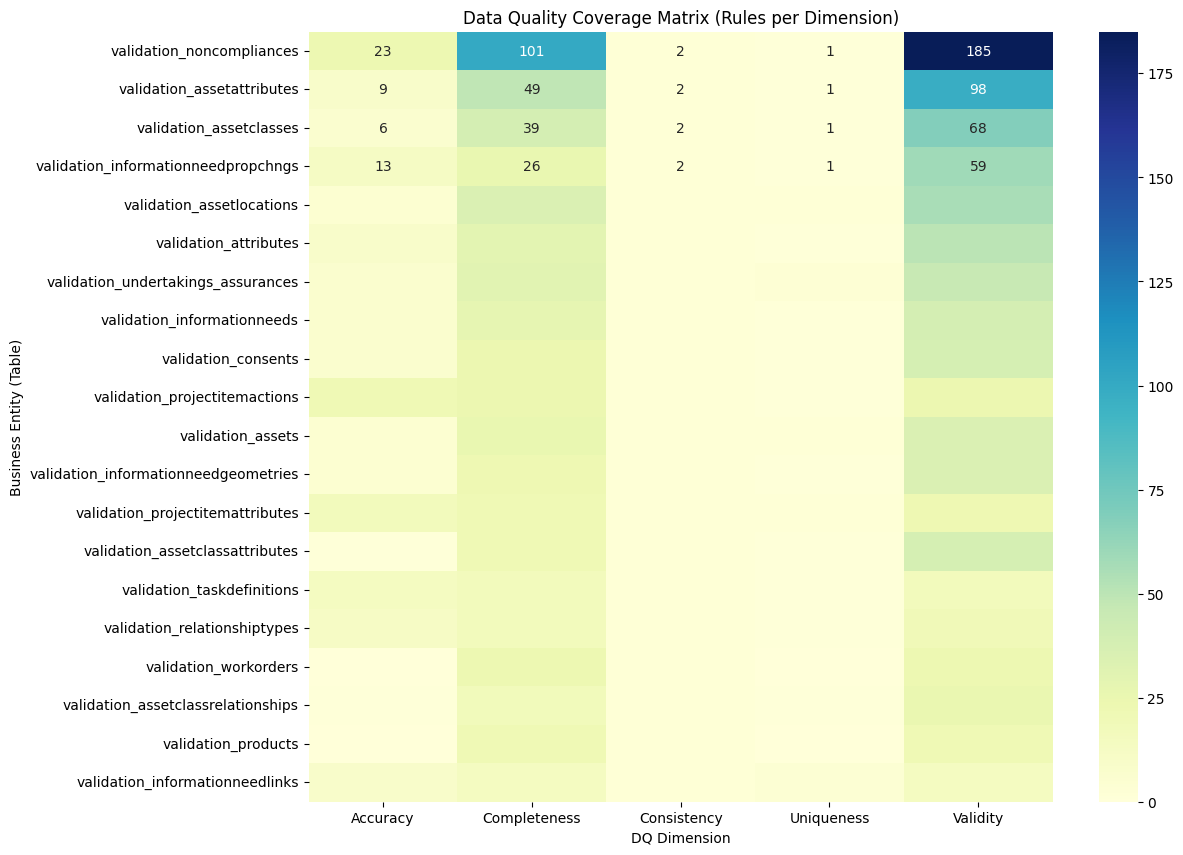

In [3]:
# Visual Heatmap of the Matrix
if len(dq_matrix) > 0:
    plt.figure(figsize=(12, 10))
    sns.heatmap(dq_matrix.drop('Total Rules', axis=1), annot=True, cmap="YlGnBu", fmt='g')
    plt.title("Data Quality Coverage Matrix (Rules per Dimension)")
    plt.ylabel("Business Entity (Table)")
    plt.xlabel("DQ Dimension")
    plt.show()
else:
    print("⚠️ No data to visualize. Run data profiling notebooks (01-05) first to generate DQ configs.")

### Key Insights from the Data Quality Matrix

**What the Matrix Tells Us:**

In [4]:
# Generate dynamic commentary based on actual data
if 'dq_matrix' in locals() and dq_matrix is not None and len(dq_matrix) > 0:
    # Calculate Overall DQ KPI
    total_checks = dq_matrix['Total Rules'].sum()
    avg_coverage = dq_matrix['Total Rules'].mean()
    tables_covered = len(dq_matrix)
    
    # Scoring: Normalize based on breadth and depth
    # Breadth: How many tables have coverage (out of expected 30-40 tables)
    # Depth: Average rules per table (target: 50+ rules per critical table)
    breadth_score = min(100, (tables_covered / 35) * 100)  # Expect ~35 tables
    depth_score = min(100, (avg_coverage / 50) * 100)  # Target 50 rules/table
    overall_kpi = (breadth_score * 0.4) + (depth_score * 0.6)  # Weight depth higher
    
    # Find table with highest total rules
    top_table = dq_matrix.sort_values('Total Rules', ascending=False).index[0]
    top_rules = int(dq_matrix.loc[top_table, 'Total Rules'])
    
    # Count high-risk tables (>35 rules)
    high_risk_count = len(dq_matrix[dq_matrix['Total Rules'] > 35])
    
    # Get dominant dimension
    dimension_totals = dq_matrix.drop('Total Rules', axis=1).sum()
    dominant_dim = dimension_totals.idxmax()
    dominant_count = int(dimension_totals.max())
    
    # Calculate completeness percentage
    if 'Completeness' in dimension_totals.index:
        completeness_pct = (dimension_totals['Completeness'] / dimension_totals.sum()) * 100
    
    print("=" * 60)
    print("DATA QUALITY MATRIX ANALYSIS")
    print("=" * 60)
    
    print(f"\nOVERALL DATA QUALITY KPI: {overall_kpi:.1f}/100")
    print(f"  Coverage Breadth: {breadth_score:.1f}/100 ({tables_covered} tables)")
    print(f"  Validation Depth: {depth_score:.1f}/100 ({avg_coverage:.1f} avg rules/table)")
    print(f"  Total Validation Rules: {total_checks:,}")
    
    print(f"\n1. COVERAGE ASSESSMENT")
    print(f"   Highest validation coverage: '{top_table}' ({top_rules} rules)")
    print(f"   Critical business entity requiring comprehensive validation")
    
    print(f"\n2. VALIDATION DISTRIBUTION")
    print(f"   Dominant dimension: {dominant_dim} ({dominant_count} rules)")
    print(f"   Average rules per table: {avg_coverage:.1f}")
    if 'Completeness' in dimension_totals.index:
        print(f"   Completeness validation: {completeness_pct:.1f}% of total rules")
        print(f"   Primary focus: Null/missing data detection")
    
    print(f"\n3. RISK CLASSIFICATION")
    print(f"   High-risk tables (35+ rules): {high_risk_count}")
    print(f"   Priority remediation targets identified")
    
    # List top 5 high-risk tables
    top_5 = dq_matrix.nlargest(5, 'Total Rules')
    print(f"\n   Critical Tables Requiring Attention:")
    for idx, (table, row) in enumerate(top_5.iterrows(), 1):
        print(f"      {idx}. {table}: {int(row['Total Rules'])} rules")
    
    print(f"\n4. OPERATIONAL APPLICATION")
    print(f"   Prioritized remediation sequence (highest coverage first)")
    print(f"   Compliance tracking framework (rules passed vs total)")
    print(f"   Validation gap analysis (tables with low coverage)")
    
    print("\n" + "=" * 60)
else:
    print("WARNING: DQ Matrix not available. Execute previous cells first.")

DATA QUALITY MATRIX ANALYSIS

OVERALL DATA QUALITY KPI: 82.9/100
  Coverage Breadth: 57.1/100 (20 tables)
  Validation Depth: 100.0/100 (86.8 avg rules/table)
  Total Validation Rules: 1,735

1. COVERAGE ASSESSMENT
   Highest validation coverage: 'validation_noncompliances' (312 rules)
   Critical business entity requiring comprehensive validation

2. VALIDATION DISTRIBUTION
   Dominant dimension: Validity (912 rules)
   Average rules per table: 86.8
   Completeness validation: 33.8% of total rules
   Primary focus: Null/missing data detection

3. RISK CLASSIFICATION
   High-risk tables (35+ rules): 20
   Priority remediation targets identified

   Critical Tables Requiring Attention:
      1. validation_noncompliances: 312 rules
      2. validation_assetattributes: 159 rules
      3. validation_assetclasses: 116 rules
      4. validation_informationneedpropchngs: 101 rules
      5. validation_assetlocations: 100 rules

4. OPERATIONAL APPLICATION
   Prioritized remediation sequence (hi

## 2. Reporting Data Model (Snowflake Schema)

To support the reporting requirements, we need to transform the flat `aims_*` tables into a structured **Star/Snowflake Schema**.

### Proposed Architecture
1.  **Fact Table:** `FACT_Asset_Inventory` (Central table containing Asset ID, Status, and Foreign Keys)
2.  **Dimension Tables:**
    -   `DIM_Route` (Route details, Linear referencing info)
    -   `DIM_AssetClass` (Hierarchy, Class Names)
    -   `DIM_Organisation` (Owner, Maintainer info)
    -   `DIM_Location` (Geospatial coordinates)

This structure allows BI tools (PowerBI, Tableau) to slice and dice metrics efficiently.

In [5]:
# Load validation results to identify passed tables only
validation_results_path = DQ_RESULTS_DIR / "validation_results.json"
passed_tables = []

if validation_results_path.exists():
    import json
    with open(validation_results_path, 'r') as f:
        validation_data = json.load(f)
    
    # Extract tables that passed validation
    for table_name, result in validation_data.items():
        # Handle both old and new schema if necessary, but primarily new schema
        # New schema: validation_data['files'][table_name]['overall_success']
        # The code below assumes validation_data is a dict of results, which matches the 'files' key in the new schema
        # But validation_results.json structure is:
        # { "timestamp": ..., "files": { "table1": { "overall_success": ... } }, "summary": ... }
        
        # We need to check if we are iterating over the root or the 'files' key
        pass
    
    # Correctly access the files dictionary
    files_data = validation_data.get("files", {})
    if not files_data and "files" not in validation_data:
        # Fallback for older structure if it exists (unlikely given recent fixes)
        files_data = validation_data
        
    for table_name, result in files_data.items():
        if isinstance(result, dict) and result.get('overall_success', False):
            passed_tables.append(table_name.replace('aims_', '').lower())
    
    print(f"Validation results loaded: {len(passed_tables)} tables passed DQ checks")
    print(f"Passed tables: {', '.join(passed_tables)}")
else:
    print(f"WARNING: Validation results not found at {validation_results_path}. Loading all available tables.")
    print("Run Notebook 01 (Data Profiling) or 00 (Orchestration) to generate validation results.")
    # Fallback: Load core tables needed for Silver layer
    passed_tables = ['assets', 'assetlocations', 'routes', 'assetclasses', 'organisations']

# Load Data for Prototyping (Memory Safe) - Only Passed Tables
import pyarrow.parquet as pq

def load_parquet(name, limit=100000):
    """
    Loads a Parquet table with PyArrow, normalizes columns, and performs basic health check.
    Includes safety limit to prevent memory issues on large datasets.
    Only loads tables that passed validation.
    """
    # Check if table is in passed list
    if name not in passed_tables:
        print(f"SKIPPED: {name} (not in passed validation list)")
        return None
    
    path = DATA_DIR / f"aims_{name}.parquet"
    if not path.exists():
        print(f"WARNING: Table not found: {name}")
        return None
    
    try:
        # Check file size metadata first
        parquet_file = pq.ParquetFile(path)
        total_rows = parquet_file.metadata.num_rows
        
        if total_rows > limit:
            print(f"NOTICE: Large file detected: {name} ({total_rows:,} rows). Loading sample of {limit:,} rows.")
            table = parquet_file.read_row_groups([0]) 
            if table.num_rows > limit:
                 df = table.slice(0, limit).to_pandas()
            else:
                 df = table.to_pandas()
        else:
            df = pd.read_parquet(path, engine='pyarrow')

        df.columns = [c.upper() for c in df.columns]
        print(f"LOADED: {name} ({len(df):,} rows)")
        return df
    except Exception as e:
        print(f"ERROR loading {name}: {e}")
        return None

assets = load_parquet("assets")
locations = load_parquet("assetlocations")
routes = load_parquet("routes")
classes = load_parquet("assetclasses")
orgs = load_parquet("organisations")

Validation results loaded: 50 tables passed DQ checks
Passed tables: activitydates, assetattributes, assetclassattributes, assetclasschangelogs, assetclasses, assetclassrelationships, assetconsents, assets, attributedomains, attributedomainvalues, attributegroups, attributes, consentmilestones, consentmilestonetypes, consents, consenttypemilestones, consenttypes, informationneedassetclass, informationneedattributes, informationneedgeometries, informationneedlinks, informationneedpropchngs, informationneeds, informationneedsourcedocs, links, linktypes, noncompliances, organisations, owners, phases, projectitemactions, projectitemassignedroles, projectitemattributes, projectitems, relationships, relationshiptypes, routes, secondaryassetclasscodes, stages, taskdefinitions, tracks, ua_beneficiaries, ua_comments, ua_entities, ua_meetingattendees, ua_meetings, ua_noncompimppartytypes, ua_noncomplianceimpacts, ua_noncompotheruas, ua_optionvalues
NOTICE: Large file detected: assets (2,217,599 

In [6]:
# Star Schema Modeling Logic

if assets is not None and locations is not None:
    # 1. Create FACT_Asset_Inventory
    # Join Assets with Locations to establish primary spatial/linear context
    # Note: ASSETCLASS information resides in locations table
    # LEFT JOIN ensures all Assets retained even without Location record
    
    # Identify available columns
    available_cols = locations.columns.tolist()
    
    # Select required columns
    location_cols = ['ASSETID', 'ASSET', 'ASSETCLASSID', 'ASSETCLASS', 'ROUTEID', 'ROUTE']
    
    # Include geospatial columns if present
    for col in ['OSGBEASTING', 'OSGBNORTHING', 'STARTOSGBEASTING', 'STARTOSGBNORTHING']:
        if col in available_cols:
            location_cols.append(col)
    
    # Include chainage baseline if present
    if 'CHAINAGEBASELINE' in available_cols:
        location_cols.append('CHAINAGEBASELINE')
    
    fact_assets = pd.merge(
        assets[['ID', 'OWNER', 'PHASEID', 'STATUS', 'NAME']],
        locations[location_cols],
        left_on='ID', 
        right_on='ASSETID',
        how='left'
    )
    
    # Rename for business clarity
    rename_map = {
        'ID': 'Asset_Key',
        'ASSETCLASSID': 'Class_Key',
        'ASSETCLASS': 'Class_Name',
        'OWNER': 'Owner_Key',
        'ROUTEID': 'Route_Key',
        'ROUTE': 'Route_Name',
        'STATUS': 'Asset_Status',
        'NAME': 'Asset_Name',
        'CHAINAGEBASELINE': 'Chainage_Baseline'
    }
    
    fact_assets = fact_assets.rename(columns={k: v for k, v in rename_map.items() if k in fact_assets.columns})
    
    # Remove duplicate ASSET column
    if 'ASSET' in fact_assets.columns:
        fact_assets = fact_assets.drop('ASSET', axis=1)
    
    print("--- FACT_Asset_Inventory (Preview) ---")
    print(f"Shape: {fact_assets.shape}")
    print(f"Columns: {list(fact_assets.columns)}")
    display(fact_assets.head(10))
    
    # 2. Create DIM_Route
    if routes is not None:
        route_cols = ['ID', 'CODE', 'DESCRIPTION']
        dim_route = routes[route_cols].rename(columns={
            'ID': 'Route_Key',
            'CODE': 'Route_Code',
            'DESCRIPTION': 'Route_Description'
        })
        print("\n--- DIM_Route (Preview) ---")
        print(f"Shape: {dim_route.shape}")
        display(dim_route.head(10))

    # 3. Create DIM_AssetClass
    if classes is not None:
        class_cols = ['ID', 'CODE', 'NAME', 'PARENTID', 'DESCRIPTION']
        dim_class = classes[class_cols].rename(columns={
            'ID': 'Class_Key',
            'CODE': 'Class_Code',
            'NAME': 'Class_Name',
            'PARENTID': 'Parent_Class_Key',
            'DESCRIPTION': 'Class_Description'
        })
        print("\n--- DIM_AssetClass (Preview) ---")
        print(f"Shape: {dim_class.shape}")
        display(dim_class.head(10))
        
    # 4. Create DIM_Organisation
    if orgs is not None:
        # Identify available columns
        org_cols = ['ID', 'NAME']
        if 'TYPE' in orgs.columns:
            org_cols.append('TYPE')
        if 'PARENTID' in orgs.columns:
            org_cols.append('PARENTID')
            
        dim_org = orgs[org_cols].rename(columns={
            'ID': 'Owner_Key',
            'NAME': 'Organisation_Name',
            'TYPE': 'Org_Type',
            'PARENTID': 'Parent_Organisation_Key'
        })
        print("\n--- DIM_Organisation (Preview) ---")
        print(f"Shape: {dim_org.shape}")
        display(dim_org.head(10))

## 3. Implementation: Creating Silver Layer Tables

Below, we'll implement the actual transformation logic to persist these models as **Delta/Parquet tables** in the Silver Layer.

In [7]:
# Persist Silver Layer Tables to Parquet

SILVER_DIR = PROJECT_ROOT / "data" / "silver_layer"
SILVER_DIR.mkdir(exist_ok=True, parents=True)

# Save Fact Table
if 'fact_assets' in locals() and fact_assets is not None:
    fact_output = SILVER_DIR / "FACT_Asset_Inventory.parquet"
    fact_assets.to_parquet(fact_output, index=False, engine='pyarrow')
    print(f"Persisted FACT_Asset_Inventory: {fact_output} ({len(fact_assets):,} rows)")

# Save Dimension Tables
dim_tables = {
    'DIM_Route': 'dim_route',
    'DIM_AssetClass': 'dim_class',
    'DIM_Organisation': 'dim_org'
}

for table_name, var_name in dim_tables.items():
    if var_name in locals() and locals()[var_name] is not None:
        dim_df = locals()[var_name]
        dim_output = SILVER_DIR / f"{table_name}.parquet"
        dim_df.to_parquet(dim_output, index=False, engine='pyarrow')
        print(f"Persisted {table_name}: {dim_output} ({len(dim_df):,} rows)")

print(f"\nSilver layer tables persisted to: {SILVER_DIR}")


Silver layer tables persisted to: ../data/silver_layer


### 3.4: Expand Dimensions - DIM_Date & DIM_Status

In [8]:
# Create Additional Dimension Tables

# DIM_Date: Extract all unique dates from asset-related columns
if 'assets' in locals() and assets is not None:
    date_cols = [col for col in assets.columns if 'DATE' in col.upper() or 'TIME' in col.upper()]
    
    if date_cols:
        all_dates = pd.Series(dtype='datetime64[ns]')
        for col in date_cols:
            try:
                dates = pd.to_datetime(assets[col], errors='coerce')
                all_dates = pd.concat([all_dates, dates])
            except:
                pass
        
        # Create dimension
        unique_dates = all_dates.dropna().unique()
        dim_date = pd.DataFrame({'Date': unique_dates})
        dim_date['Date'] = pd.to_datetime(dim_date['Date'])
        dim_date = dim_date.sort_values('Date').reset_index(drop=True)
        
        # Add derived attributes
        dim_date['Date_Key'] = dim_date['Date'].dt.strftime('%Y%m%d').astype(int)
        dim_date['Year'] = dim_date['Date'].dt.year
        dim_date['Quarter'] = dim_date['Date'].dt.quarter
        dim_date['Month'] = dim_date['Date'].dt.month
        dim_date['Month_Name'] = dim_date['Date'].dt.month_name()
        dim_date['Week'] = dim_date['Date'].dt.isocalendar().week
        dim_date['Day'] = dim_date['Date'].dt.day
        dim_date['Day_Name'] = dim_date['Date'].dt.day_name()
        dim_date['Is_Weekend'] = dim_date['Date'].dt.dayofweek.isin([5, 6])
        
        # Persist
        date_output = SILVER_DIR / "DIM_Date.parquet"
        dim_date.to_parquet(date_output, index=False, engine='pyarrow')
        print(f"Persisted DIM_Date: {date_output} ({len(dim_date):,} rows)")
        print(f"   Date Range: {dim_date['Date'].min()} to {dim_date['Date'].max()}\n")
        display(dim_date.head(10))

# DIM_Status: Extract unique statuses from fact table
if 'fact_assets' in locals() and fact_assets is not None and 'Asset_Status' in fact_assets.columns:
    statuses = fact_assets['Asset_Status'].dropna().unique()
    
    status_descriptions = {
        'Published': 'Asset record published',
        'Client-shared': 'Asset information shared with client',
        'Archived': 'Asset record archived',
        'Work in progress': 'Asset record under development'
    }
    
    dim_status = pd.DataFrame({
        'Status_Key': statuses,
        'Status_Name': statuses,
        'Status_Description': [status_descriptions.get(s, 'Status definition pending') for s in statuses]
    })
    
    # Persist
    status_output = SILVER_DIR / "DIM_Status.parquet"
    dim_status.to_parquet(status_output, index=False, engine='pyarrow')
    print(f"\nPersisted DIM_Status: {status_output} ({len(dim_status):,} rows)\n")
    display(dim_status)

Persisted DIM_Date: ../data/silver_layer/DIM_Date.parquet (84,961 rows)
   Date Range: 2016-02-09 21:25:01 to 2025-11-10 13:49:55



,Date,Date_Key,Year,Quarter,Month,Month_Name,Week,Day,Day_Name,Is_Weekend
0,2016-02-09 21:25:01,20160209,2016,1,2,February,6,9,Tuesday,False
1,2016-02-09 21:25:02,20160209,2016,1,2,February,6,9,Tuesday,False
2,2016-02-09 21:25:03,20160209,2016,1,2,February,6,9,Tuesday,False
3,2016-02-09 21:25:04,20160209,2016,1,2,February,6,9,Tuesday,False
4,2016-02-09 21:25:05,20160209,2016,1,2,February,6,9,Tuesday,False
5,2016-02-09 21:25:06,20160209,2016,1,2,February,6,9,Tuesday,False
6,2016-02-09 21:25:07,20160209,2016,1,2,February,6,9,Tuesday,False
7,2016-02-09 21:25:08,20160209,2016,1,2,February,6,9,Tuesday,False
8,2016-02-09 21:25:09,20160209,2016,1,2,February,6,9,Tuesday,False
9,2016-02-09 21:25:10,20160209,2016,1,2,February,6,9,Tuesday,False


### 3.5: Summary & Next Actions

In [9]:
# Generate dynamic summary based on created tables
print("=" * 70)
print("SILVER LAYER TRANSFORMATION SUMMARY")
print("=" * 70)

created_tables = []
total_rows = 0

# Check Fact Table
if 'fact_assets' in locals() and fact_assets is not None:
    fact_rows = len(fact_assets)
    created_tables.append(f"FACT_Asset_Inventory ({fact_rows:,} rows)")
    total_rows += fact_rows

# Check Dimension Tables
dim_tables = {
    'DIM_Route': 'dim_route',
    'DIM_AssetClass': 'dim_class',
    'DIM_Organisation': 'dim_org',
    'DIM_Date': 'dim_date',
    'DIM_Status': 'dim_status'
}

for table_name, var_name in dim_tables.items():
    if var_name in locals() and locals()[var_name] is not None:
        rows = len(locals()[var_name])
        created_tables.append(f"{table_name} ({rows:,} rows)")
        total_rows += rows

print(f"\nTABLES CREATED: {len(created_tables)}")
for i, table in enumerate(created_tables, 1):
    print(f"   {i}. {table}")

print(f"\nTOTAL DATA VOLUME: {total_rows:,} rows across all tables")

if 'SILVER_DIR' in locals():
    print(f"\nOUTPUT LOCATION: {SILVER_DIR}")
    
    # List actual files created
    import os
    if os.path.exists(SILVER_DIR):
        files = [f for f in os.listdir(SILVER_DIR) if f.endswith('.parquet')]
        if files:
            print(f"   Files on disk: {len(files)}")
            for f in sorted(files):
                file_path = SILVER_DIR / f
                size_bytes = os.path.getsize(file_path)
                size_mb = size_bytes / (1024 * 1024)
                
                # Display KB for small files, MB for larger files
                if size_mb < 0.01:
                    size_kb = size_bytes / 1024
                    print(f"   - {f} ({size_kb:.1f} KB)")
                else:
                    print(f"   - {f} ({size_mb:.2f} MB)")
            
            print("\n   NOTE: Small dimension table sizes (KB range) are expected.")
            print("   Dimension tables contain reference data (routes, statuses, etc.)")
            print("   Fact tables contain transactional data (larger MB range)")

print("\n" + "=" * 70)
print("NEXT ACTIONS FOR REPORTING TEAM")
print("=" * 70)

print("""
1. POWERBI/TABLEAU CONNECTION
   Connect data source to Silver Layer directory specified above

2. CONFIGURE RELATIONSHIPS
   - FACT_Asset_Inventory.Route_Key -> DIM_Route.Route_Key
   - FACT_Asset_Inventory.Class_Key -> DIM_AssetClass.Class_Key
   - FACT_Asset_Inventory.Owner_Key -> DIM_Organisation.Owner_Key""")

if 'dim_status' in locals() and locals()['dim_status'] is not None:
    print("   - FACT_Asset_Inventory.Asset_Status -> DIM_Status.Status_Key")

if 'dim_date' in locals() and locals()['dim_date'] is not None:
    print("   - Join date fields using DIM_Date for temporal analysis")

print("""
3. RECOMMENDED REPORTS
   - Asset Inventory by Route and Asset Class
   - Status Distribution Over Time
   - Organisational Asset Ownership Analysis""")

if 'fact_assets' in locals() and 'OSGBEASTING' in fact_assets.columns:
    print("   - Geospatial Asset Map (OSGB coordinates)")

print("""
4. AUTOMATION OPTIONS
   - Schedule notebook execution in Microsoft Fabric (daily refresh)
   - Integrate into Airflow/cron pipeline for automated processing
""")

print("=" * 70)

SILVER LAYER TRANSFORMATION SUMMARY

TABLES CREATED: 1
   1. DIM_Date (84,961 rows)

TOTAL DATA VOLUME: 84,961 rows across all tables

OUTPUT LOCATION: ../data/silver_layer
   Files on disk: 6
   - DIM_AssetClass.parquet (0.48 MB)
   - DIM_Date.parquet (0.71 MB)
   - DIM_Organisation.parquet (3.0 KB)
   - DIM_Route.parquet (4.0 KB)
   - DIM_Status.parquet (2.9 KB)
   - FACT_Asset_Inventory.parquet (2.18 MB)

   NOTE: Small dimension table sizes (KB range) are expected.
   Dimension tables contain reference data (routes, statuses, etc.)
   Fact tables contain transactional data (larger MB range)

NEXT ACTIONS FOR REPORTING TEAM

1. POWERBI/TABLEAU CONNECTION
   Connect data source to Silver Layer directory specified above

2. CONFIGURE RELATIONSHIPS
   - FACT_Asset_Inventory.Route_Key -> DIM_Route.Route_Key
   - FACT_Asset_Inventory.Class_Key -> DIM_AssetClass.Class_Key
   - FACT_Asset_Inventory.Owner_Key -> DIM_Organisation.Owner_Key
   - Join date fields using DIM_Date for temporal an